<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/CC_BY.png"><br />

Adapted by Valdis Saulespurens from [Nathan Kelber](http://nkelber.com) and Ted Lawless for [JSTOR Labs](https://labs.jstor.org/) under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/)<br />

____
# Exploring Word Frequencies

**Description:**
This [notebook](https://docs.constellate.org/key-terms/#jupyter-notebook) shows how to find the most common words in a
[dataset](https://docs.constellate.org/key-terms/#dataset). The following processes are described:

* Loading our dataset in Pandas DataFrame
* Filtering based on a pre-processed ID list
* Filtering based on a [stop words list](https://docs.constellate.org/key-terms/#stop-words)
* Using a `Counter()` object to get the most common words
* Visualizating results

**Use Case:** For Learners (Detailed explanation, not ideal for researchers)


**Difficulty:** Intermediate

**Completion time:** 60 minutes

**Knowledge Required:** 
* Python Basics ([Start Python Basics I](./python-basics-1.ipynb))

**Knowledge Recommended:**

* [Working with Dataset Files](./working-with-dataset-files.ipynb)
* [Pandas I](./pandas-1.ipynb)
* [Counter Objects](./counter-objects.ipynb)
* [Creating a Stopwords List](./creating-stopwords-list.ipynb)

**Data Format:** [JSON Lines (.jsonl)](https://docs.constellate.org/key-terms/#jsonl)

**Libraries Used:**

* [NLTK](https://docs.constellate.org/key-terms/#nltk) to help [clean](https://docs.constellate.org/key-terms/#clean-data) up our dataset
* [Counter](https://docs.constellate.org/key-terms/#python-counter) from **Collections** to help sum up our word frequencies
* [Matplotlib](https://matplotlib.org/stable/index.html) - visualizations
* [WordCloud](https://pypi.org/project/wordcloud/) - for wordcloud visualizations
* [Plotly](https://plotly.com/python/) - for interactive visualizations

**Research Pipeline:**

1. Build a dataset
2. Create a "Pre-Processing CSV" with [Exploring Metadata](./exploring-metadata.ipynb) (Optional)
3. Create a "Custom Stopwords List" with [Creating a Stopwords List](./creating-stopwords-list.ipynb) (Optional)
4. Complete the word frequencies analysis with this notebook
___

In [1]:

from collections import Counter
import os
import pandas
import requests

In [2]:
# Approach 2 reading from a web address 
url = "https://github.com/ValRCS/BSSDH_22/raw/main/corpora/lv_old_newspapers_5k.tsv"

df = pandas.read_csv(url, sep="\t") 
df.head()

,Language,Source,Date,Text
0,Latvian,rekurzeme.lv,2008/09/04,"""Viņa pirmsnāves zīmītē bija rakstīts vienīgi ..."
1,Latvian,diena.lv,2012/01/10,info@zurnalistiem.lv
2,Latvian,bauskasdzive.lv,2007/12/27,"Bhuto, kas Pakistānā no trimdas atgriezās tika..."
3,Latvian,bauskasdzive.lv,2008/10/08,Plkst. 4.00 Samoilovs / Pļaviņš (pludmales vol...
4,Latvian,diena.lv,2011/10/05,"CVK bija vērsusies Skaburska, lūdzot izskaidro..."


In [3]:
df.shape

(4999, 4)

### Load Stopwords List

If you have created a stopword list in the stopwords notebook, we will import it here. (You can always modify the CSV file to add or subtract words then reload the list.) Otherwise, we'll load the NLTK [stopwords](https://docs.constellate.org/key-terms/#stop-words) list automatically.

In [ ]:
    # how to find all languages stopwords built in NLTK
    # https://stackoverflow.com/questions/54573853/nltk-available-languages-for-stopwords
    # bigger collection of all stopwords
    # https://github.com/stopwords-iso
    # latvian https://github.com/stopwords-iso/stopwords-lv/raw/master/stopwords-lv.txt

In [4]:
url = "https://github.com/stopwords-iso/stopwords-lv/raw/master/stopwords-lv.txt"
stop_words = [] # len(stop_words) is 0 here
response = requests.get(url)
if response.status_code == 200:  # 200 means our request was succesfful, if we got 404 we did something wrong
    stop_words = response.text.split()
else:
    print("Oops Error code", response.status_code)
len(stop_words)


161

In [5]:
stop_words[:5]

['aiz', 'ap', 'apakš', 'apakšpus', 'ar']

In [6]:
with open("stop_words.csv", "w", encoding="utf-8") as f:
    f.write(response.text) # csv is really text here no commas at all

In [10]:
# Load a custom data/stop_words.csv if available
# Otherwise, load the nltk stopwords list in English

# Create an empty Python list to hold the stopwords
# you would run this cell if you did not have stop_words loaded already
stop_words = [] # we destroy any previous stop_words list

# The filename of the custom data/stop_words.csv file # it could have been .txt
stopwords_list_filename = 'stop_words.csv'

# useful when we are not sure if the file name exists
if os.path.exists(stopwords_list_filename):
    import csv  #Python built in csv library, smaller than Pandas if you do not need anything fancy
    with open(stopwords_list_filename, 'r') as f:
        stop_words = [w[0] for w in list(csv.reader(f))]
    print('Custom stopwords list loaded from CSV')
else:
    # Load the NLTK stopwords list
    import nltk
    nltk.download('stopwords')
    from nltk.corpus import stopwords

    
    stop_words = stopwords.words('english') # change it to your language if it is supported by nltk

    print('NLTK stopwords list loaded')
len(stop_words)

Custom stopwords list loaded from CSV


161

In [11]:
stop_words[:5]

['aiz', 'ap', 'apakš', 'apakšpus', 'ar']

In [ ]:
stop_words[:3]

['aiz', 'ap', 'apakš']

### Gather unigrams again with extra cleaning steps
In addition to using a stopwords list, we will clean up the tokens by lowercasing all tokens and combining them. This will combine tokens with different capitalization such as "quarterly" and "Quarterly." We will also remove any tokens that are not alphanumeric.

In [12]:
df.head(2)

,Language,Source,Date,Text
0,Latvian,rekurzeme.lv,2008/09/04,"""Viņa pirmsnāves zīmītē bija rakstīts vienīgi ..."
1,Latvian,diena.lv,2012/01/10,info@zurnalistiem.lv


In [13]:
documents = list(df.Text)
len(documents)  # so list of 4999 Strings

4999

In [14]:
text = "\n".join(documents)
len(text)

1415137

In [16]:
text_lower = text.lower()
len(text_lower)

1415137

In [17]:
tokens = text_lower.split()  # here major alternative would nltk's word_tokenize
# with .split() our foo, and foo. and foo will be different tokens
len(tokens) 

193133

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
tokens = nltk.word_tokenize(text_lower)
len(tokens)

231727

In [18]:
type(tokens) # we have a list of tokens

list

In [19]:
type(tokens[0]) # each token is a string

str

In [21]:
"." in tokens

True

In [25]:
# some extra cleanup we want to get rid of 
words = [token for token in tokens if token.isalnum()] # so called list comprehension 
# we loop through tokens and filter out items using our if statement
len(words)

187194

In [26]:
words[:10]

['viņa',
 'pirmsnāves',
 'zīmītē',
 'bija',
 'rakstīts',
 'vienīgi',
 'par',
 'smēķēšanas',
 'aizlieguma',
 'radītajiem']

In [27]:
stop_words[:5]

['aiz', 'ap', 'apakš', 'apakšpus', 'ar']

In [29]:
# we keep only those words that are not in our stop_word list
words_clean = [word for word in words if word not in stop_words]
len(words_clean)

151283

In [30]:
# Gather unigramCounts from documents 
# and apply the processing.

word_frequency = Counter(words_clean)
word_frequency.most_common(10)


[('kas', 1084),
 ('nav', 862),
 ('to', 841),
 ('latvijas', 657),
 ('tas', 608),
 ('valsts', 522),
 ('vēl', 395),
 ('ko', 373),
 ('kad', 337),
 ('gada', 335)]

## Display Results
Finally, we will display the 20 most common words by using the `.most_common()` method on the `Counter()` object.

In [31]:
# Print the most common processed unigrams and their counts
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

kas                  1084
nav                  862
to                   841
latvijas             657
tas                  608
valsts               522
vēl                  395
ko                   373
kad                  337
gada                 335
viņš                 327
laikā                323
viņa                 317
ļoti                 282
kur                  275
vairāk               275
darba                273
savu                 266
latvijā              262
šo                   260
gadā                 257
es                   256
būtu                 249
gadu                 247
varētu               245


## Export Results to a CSV File
The word frequency data can be exported to a CSV file.

In [32]:
len(word_frequency.most_common()) # so about 40k because we did not stem nor lemmatize

40781

In [33]:
# Add output method to csv
import csv # this is built into Python

with open('word_frequencies.csv', 'w', encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(['unigram', 'count']) # write header
    for gram, count in word_frequency.most_common():
        writer.writerow([gram, count]) # we go row by row and write data
    

## Create a Word Cloud to Visualize the Data
A visualization using the WordCloud library in Python. To learn more about customizing a wordcloud, [see the documentation](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html). 

In [37]:
# Add wordcloud
from wordcloud import WordCloud
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [34]:
### Download cloud image for our word cloud shape
import urllib.request # this is built in library used by requests
download_url = 'https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/sample_cloud.png'
urllib.request.urlretrieve(download_url, 'sample_cloud.png')

('sample_cloud.png', <http.client.HTTPMessage at 0x7f9435ff3810>)

In [35]:
type(word_frequency) # this is what we will pass to our wordcloud generator

collections.Counter

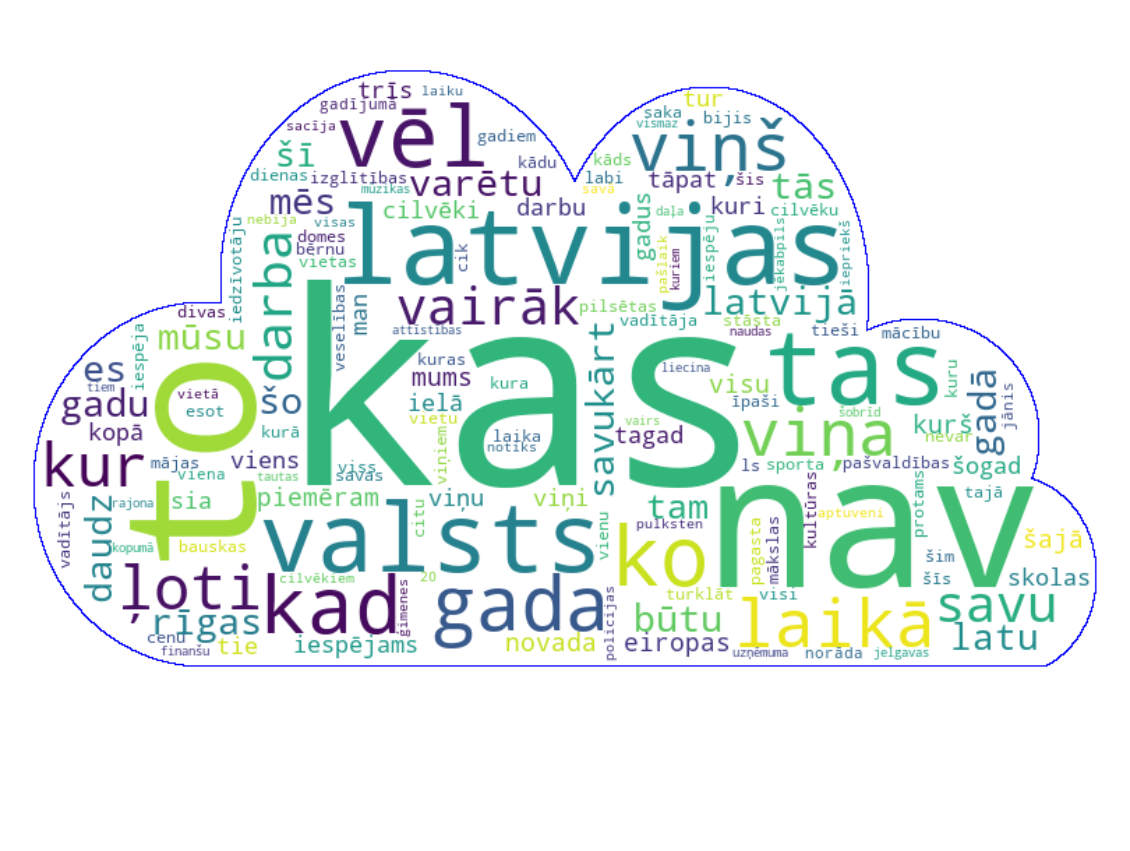

In [38]:
# Create a wordcloud from our data

# Adding a mask shape of a cloud to your word cloud
# By default, the shape will be a rectangle
# You can specify any shape you like based on an image file
cloud_mask = np.array(Image.open('sample_cloud.png')) # Specifies the location of the mask shape
cloud_mask = np.where(cloud_mask > 3, 255, cloud_mask) # this line will take all values greater than 3 and make them 255 (white)

### Specify word cloud details
wordcloud = WordCloud(
    width = 800, # Change the pixel width of the image if blurry
    height = 600, # Change the pixel height of the image if blurry
    background_color = "white", # Change the background color
    colormap = 'viridis', # The colors of the words, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    max_words = 150, # Change the max number of words shown
    min_font_size = 4, # Do not show small text
    
    # Add a shape and outline (known as a mask) to your wordcloud
    contour_color = 'blue', # The outline color of your mask shape
    mask = cloud_mask, # 
    contour_width = 1
).generate_from_frequencies(word_frequency) # so wordcloud is smart enought to use a counter object

# save wordcloud to file
wordcloud.to_file("my_wordcloud.png")
# alternative would be to right click save image as to save locally to your computer

mpl.rcParams['figure.figsize'] = (20,20) # Change the image size displayed
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
long_words = [word for word in words_clean if len(word) > 3] # so we want to only see long words
len(long_words)

139359

In [40]:
long_word_frequency = Counter(long_words)
long_word_frequency.most_common(10)

[('latvijas', 657),
 ('valsts', 522),
 ('gada', 335),
 ('viņš', 327),
 ('laikā', 323),
 ('viņa', 317),
 ('ļoti', 282),
 ('vairāk', 275),
 ('darba', 273),
 ('savu', 266)]

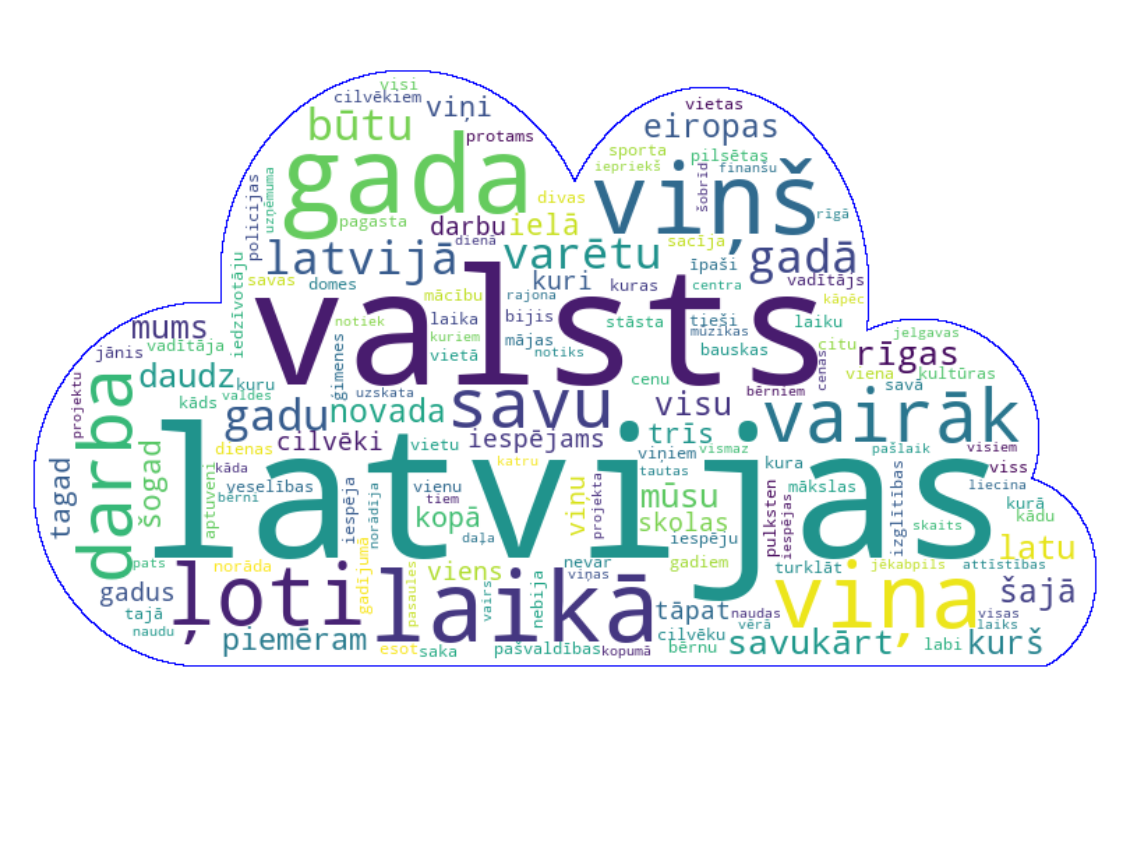

In [41]:
# Create a wordcloud from our data

# Adding a mask shape of a cloud to your word cloud
# By default, the shape will be a rectangle
# You can specify any shape you like based on an image file
cloud_mask = np.array(Image.open('sample_cloud.png')) # Specifies the location of the mask shape
cloud_mask = np.where(cloud_mask > 3, 255, cloud_mask) # this line will take all values greater than 3 and make them 255 (white)

### Specify word cloud details
wordcloud = WordCloud(
    width = 800, # Change the pixel width of the image if blurry
    height = 600, # Change the pixel height of the image if blurry
    background_color = "white", # Change the background color
    colormap = 'viridis', # The colors of the words, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    max_words = 150, # Change the max number of words shown
    min_font_size = 4, # Do not show small text
    
    # Add a shape and outline (known as a mask) to your wordcloud
    contour_color = 'blue', # The outline color of your mask shape
    mask = cloud_mask, # 
    contour_width = 1
).generate_from_frequencies(long_word_frequency) # so wordcloud is smart enought to use a counter object

# save wordcloud to file
wordcloud.to_file("wordcloud_length_4_or_Longer.png")
# alternative would be to right click save image as to save locally to your computer

mpl.rcParams['figure.figsize'] = (20,20) # Change the image size displayed
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
# now let's creat some bubble charts for our most frequent words
# https://plotly.com/python/bubble-charts/
import plotly.graph_objects as go # we import submodule from plotly


In [43]:
import plotly

In [44]:
plotly.__version__

'5.5.0'

In [45]:
# we will need to separate our frequency data into x axis - words
# y axis will be the frequency
# we start with two blank lists
X = [] # we could have used any name but X symbolizes array/list of x values
Y = []
max_count = 100
for x,y in word_frequency.most_common(max_count):
    X.append(x)
    Y.append(y)
# there are other methods for doing the above but this one is simple
X[:5],Y[:5]


(['kas', 'nav', 'to', 'latvijas', 'tas'], [1084, 862, 841, 657, 608])

In [46]:
word_frequency.most_common(5)

[('kas', 1084), ('nav', 862), ('to', 841), ('latvijas', 657), ('tas', 608)]

In [47]:
# Basic Scatter Plot 
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers') # there are other modes such as line mode or combined line+marker mode
])

fig.show()

In [49]:
# we will use length of word to determine size
sizes = [len(x) for x in X] # i go through all the words in X and generated a corresponding list of their lengths
sizes[:5]

[3, 3, 2, 8, 3]

In [50]:
# Utilize size in the plot
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=sizes) # i could have also used a constant size here instead of a list of sizes
])

fig.show()

In [51]:
# if we are not happy with the size we can adjust it ad hoc - use your own judgment
big_sizes = [n*4 for n in sizes] # just for plotly
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes)
])

fig.show()

In [53]:
fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes,
    #marker_color='red'
    marker_color='violet'
    ) # so single color works
])

fig.show()

In [54]:
# we can assign custom colors for all 100 words 
# first we will take 4 colors and simply multiply / pad to have 100 colors - repeating every 4
colors = ['rgb(93, 164, 214)', 'rgb(255, 144, 14)','rgb(44, 160, 101)', 'rgb(255, 65, 54)'] * 25 # we need 100 colors
len(colors)      # so by * 25 I made a list of 100 out of my initial list of 4 values        

100

In [55]:
["Valdis","beer"] * 5

['Valdis',
 'beer',
 'Valdis',
 'beer',
 'Valdis',
 'beer',
 'Valdis',
 'beer',
 'Valdis',
 'beer']

In [56]:
colors[:9]

['rgb(93, 164, 214)',
 'rgb(255, 144, 14)',
 'rgb(44, 160, 101)',
 'rgb(255, 65, 54)',
 'rgb(93, 164, 214)',
 'rgb(255, 144, 14)',
 'rgb(44, 160, 101)',
 'rgb(255, 65, 54)',
 'rgb(93, 164, 214)']

In [57]:

fig = go.Figure(data=[go.Scatter(
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes,
    marker_color=colors # determines colors, you could supply single color as well as string))
)])
fig.show()

In [58]:
# let us create a function that will create custom color for word
# here we are still using length but could use anything else
# one good use would be Part of Speech - POS if you have it
def get_custom_color(word):
    return f"rgb({max(0, 255 - len(word) * 15)}, 164, 214)" # purplish this example shows how you can do calculations inside { }

In [59]:
get_custom_color("Uldis")

'rgb(180, 164, 214)'

In [60]:
# so for each word in X we are going to generate a custom color depending on what get_custom_color returns
custom_colors = [get_custom_color(w) for w in X]
custom_colors[:3]

['rgb(210, 164, 214)', 'rgb(210, 164, 214)', 'rgb(225, 164, 214)']

In [68]:
file_name = "lv_old_newspapers_5k.tsv"
# final bubbly chart with custom colors and sizes
fig = go.Figure(
    data=[go.Scatter(
    
    x=X, y=Y,
    mode='markers',
    marker_size=big_sizes,
    marker_color=custom_colors)
])
# example on how to add title , xaxis,yaxis, and custom font and sizes
fig.update_layout(
    title=f"Word frequency for {file_name}",
    xaxis_title="Words",
    yaxis_title="Frequency",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)

fig.show()

In [ ]:
# Try creating a word_frequency for your own data now
# start with basic plot and then proceed to more customization